In [1]:
### General ###
import os
import sys
import copy
from tqdm import tqdm
import pickle
import random
import warnings
warnings.filterwarnings("ignore")

### Data Wrangling ###
import numpy as np
import pandas as pd
from scipy import stats
from datetime import datetime, timedelta

### Data Visualization ###
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

### Machine Learning ###
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import VarianceThreshold
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import lightgbm as lgb
import xgboost as xgb

### Deep Learning ###
import torch
from torch import nn
import torch.optim as optim
from torch.nn import functional as F
from torch.nn.modules.loss import _WeightedLoss
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Tabnet 
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetRegressor

# 한글 폰트 설정
from statsmodels import robust
from matplotlib import font_manager, rc
%matplotlib inline

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

In [395]:
# 데이터 불러오기
train = pd.read_csv('data/trainset.csv')
test = pd.read_csv('data/testset_final.csv')

# susbmssion
submission = pd.read_csv('data/sample_submission_final.csv')

In [396]:
train = train.drop(['매니저주소', '매니저최초가입일', '매니저최초서비스일'], axis=1)

In [397]:
train.shape, test.shape, submission.shape

((23009, 30), (4244, 29), (4244, 2))

In [398]:
train.iloc[:, :20].head(2)

,SEQ,접수일,접수시각,장기서비스여부,최초서비스일,전체회차,현재회차,서비스일자,서비스시작시간,서비스종료시간,기존고객여부,결재형태,서비스주소,주거형태,평수,고객가입일,반려동물,부재중여부,우선청소,쿠폰사용여부
0,T06420,2019-07-09,NaN,1,2019-07-15,3,3,2019-07-29,9:00:00,13:00:00,1,무통장입금,충남 천안시,일반주택,NaN,2019-04-22,NaN,NaN,NaN,0
1,T15430,2019-07-12,NaN,1,2019-07-15,4,3,2019-08-20,10:00:00,16:00:00,1,무통장입금,충남 천안시,일반주택,NaN,2019-05-21,없음,NaN,NaN,0


In [399]:
train.iloc[:, 20:].head(2)

,매니저생년월일,매니저성별,매니저사용휴대폰,매니저이동방법,근무가능지역,CS교육이수여부,청소교육이수여부,부재중서비스가능여부,추천인여부,매칭성공여부
0,1956-04-19,0,안드로이드,대중교통,서울,0.0,0.0,1,0,0
1,1976-06-10,0,안드로이드,대중교통,천안/아산,1.0,1.0,1,0,0


In [400]:
submission.head(2)

,SEQ,pred
0,T54370,0.5
1,T47892,0.5


## 기본 전처리

In [401]:
# 날짜 처리
train['접수일'] = pd.to_datetime(train['접수일'])
train['최초서비스일'] = pd.to_datetime(train['최초서비스일'])
train['서비스일자'] = pd.to_datetime(train['서비스일자'])
train['고객가입일'] = pd.to_datetime(train['고객가입일'])
train['매니저생년월일'] = pd.to_datetime(train['매니저생년월일']).dt.year

# 시간 처리
train['서비스시작시간'] = pd.to_datetime(train['서비스시작시간'], format='%H:%M:%S')
train['서비스종료시간'] = pd.to_datetime(train['서비스종료시간'], format='%H:%M:%S')
train['서비스시작시간'] = train['서비스시작시간'].dt.hour
train['서비스종료시간'] = train['서비스종료시간'].dt.hour

# 날짜 처리
test['접수일'] = pd.to_datetime(test['접수일'])
test['최초서비스일'] = pd.to_datetime(test['최초서비스일'])
test['서비스일자'] = pd.to_datetime(test['서비스일자'])
test['고객가입일'] = pd.to_datetime(test['고객가입일'])
#test['매니저생년월일'] = pd.to_datetime(test['매니저생년월일'])

# 시간 처리
test['서비스시작시간'] = pd.to_datetime(test['서비스시작시간'], format='%H:%M:%S')
test['서비스종료시간'] = pd.to_datetime(test['서비스종료시간'], format='%H:%M:%S')
test['서비스시작시간'] = test['서비스시작시간'].dt.hour
test['서비스종료시간'] = test['서비스종료시간'].dt.hour

In [402]:
# 서비스소요시간
train['서비스소요시간'] = train['서비스종료시간'] - train['서비스시작시간']
test['서비스소요시간'] = test['서비스종료시간'] - test['서비스시작시간']

# 회차 관련
train['회차사용비율'] = train['현재회차'] / train['전체회차']
test['회차사용비율'] = test['현재회차'] / test['전체회차']
train['남은회차'] = train['전체회차'] - train['현재회차']
test['남은회차'] = test['전체회차'] - test['현재회차']
train['남은회차*회차사용비율'] = train['남은회차'] * train['회차사용비율']
test['남은회차*회차사용비율'] = test['남은회차'] * test['회차사용비율']

# 서비스일자 관련
train['최초서비스일_접수일'] = train['최초서비스일'] - train['접수일']
test['최초서비스일_접수일'] = test['최초서비스일'] - test['접수일']
train['서비스일자_최초서비스일'] = train['서비스일자'] - train['최초서비스일']
test['서비스일자_최초서비스일'] = test['서비스일자'] - test['최초서비스일']

In [403]:
# timedelta 형식 feature -> int형식으로
train['최초서비스일_접수일'] = train['최초서비스일_접수일'].dt.days.astype('int16')
test['최초서비스일_접수일'] = test['최초서비스일_접수일'].dt.days.astype('int16')

train['서비스일자_최초서비스일'] = train['서비스일자_최초서비스일'].dt.days.astype('int16')
test['서비스일자_최초서비스일'] = test['서비스일자_최초서비스일'].dt.days.astype('int16')

In [404]:
train['서비스사용_term'] = (train['서비스일자_최초서비스일'] / train['현재회차']).fillna(0)
test['서비스사용_term'] = (test['서비스일자_최초서비스일'] / test['현재회차']).fillna(0)

In [405]:
train['서비스사용_term_ratio'] = (train['서비스일자_최초서비스일'] / (train['최초서비스일_접수일']+1)).fillna(0)
test['서비스사용_term_ratio'] = (test['서비스일자_최초서비스일'] / (test['최초서비스일_접수일']+1)).fillna(0)

In [406]:
train['시간추가여부'] = train['서비스소요시간'].apply(lambda x : 1 if x not in ([2, 4, 6, 8, 10]) else 0)
test['시간추가여부'] = test['서비스소요시간'].apply(lambda x : 1 if x not in ([2, 4, 6, 8, 10]) else 0)

In [407]:
train['서비스종료시작_ratio'] = train['서비스시작시간'] / train['서비스종료시간']
test['서비스종료시작_ratio'] = test['서비스시작시간'] / test['서비스종료시간']

In [408]:
# 매니저나이
train['매니저나이'] = train['매니저생년월일'].apply(lambda x : 2021 - x)
test['매니저나이'] = test['매니저생년월일'].apply(lambda x : 2021 - x)

운영시간

 - 4시간 : 오전 9:00 ~ 오후 1:00 / 오후 2:00 ~ 오후 6:00
   (기본 스케줄이며 상황에 따라 변경 가능)
   
 - 8시간 : 오전 9:00 ~ 오후 6:00 (휴게1시간 적용 / 매니저에게 중식 또는 중식비 제공 필수)
 
 - 10평대인 경우에만 2시간 서비스가 가능합니다
 
 https://helper.veteranscout.co.kr/house/house_mng

In [409]:
train.loc[train['서비스소요시간'] <= 3, '평수'] = train.loc[train['서비스소요시간'] <= 3, '평수'].fillna('10평대')

In [410]:
test.loc[test['서비스소요시간'] <= 3, '평수'] = test.loc[test['서비스소요시간'] <= 3, '평수'].fillna('10평대')

서비스 가능 지역
- 서울 / 천안, 아산, 평택 / 원주 / 부산 / 광주

### 고객 정보

In [411]:
# 장기서비스여부 / 기존고객여부 / 결재형태 / 서비스주소 / 주거형태 / 평수 / 고객가입일 / 반려동물 / 부재중여부 / 우선청소 /
# 쿠폰사용여부

In [412]:
# 고객 열 결측치 개수
na_sum = []
for i in range (0, train.shape[0], 1):
    na_all = train.iloc[i:i+1, 3:20].isna().sum().sum()
    na_sum.append(na_all)

na_sum_te = []
for i in range (0, test.shape[0], 1):
    na_all = test.iloc[i:i+1, 3:20].isna().sum().sum()
    na_sum_te.append(na_all)

na_df = pd.DataFrame(na_sum)
na_df.columns = ['na값']

na_df_te = pd.DataFrame(na_sum_te)
na_df_te.columns = ['na값']

train = pd.concat([train, na_df], axis=1)
test = pd.concat([test, na_df_te], axis=1)

In [413]:
train['반려동물'] = train['반려동물'].apply(lambda x: 0 if x=='없음' else 1 
                                    if x in ['개', '고양이', '기타', '개,고양이', '고양이,기타', '개,기타'] else x)
test['반려동물'] = test['반려동물'].apply(lambda x: 0 if x=='없음' else 1 
                                  if x in ['개', '고양이', '기타', '개,고양이', '고양이,기타', '개,기타'] else x)

### 매니저 정보

In [414]:
# public LB 1위 민석피셜 - 매니저를 살리려고 노력했다 -> 매니저 피처에 집중

In [415]:
# 매니저생년월일 / 매니저성별 / 매니저사용휴대폰 / 매니저이동방법 / 근무가능지역 / CS교육이수여부 / 청소교육이수여부 / 
# 부재중서비스가능여부 / 추천인여부 / 매니저나이

In [416]:
train[['매니저생년월일', '매니저성별', '매니저사용휴대폰', '매니저이동방법', '근무가능지역', 'CS교육이수여부', '청소교육이수여부',
       '부재중서비스가능여부', '추천인여부', '매니저나이']].head(1)

,매니저생년월일,매니저성별,매니저사용휴대폰,매니저이동방법,근무가능지역,CS교육이수여부,청소교육이수여부,부재중서비스가능여부,추천인여부,매니저나이
0,1956,0,안드로이드,대중교통,서울,0.0,0.0,1,0,65


In [417]:
train[train['서비스소요시간'] == train['서비스소요시간'].max()]['평수'].unique()

array([nan, '10평대', '30평대', '20평대'], dtype=object)

In [418]:
test[test['서비스소요시간'] == test['서비스소요시간'].max()]['평수'].unique()

array([nan, '30평대', '20평대', '10평대'], dtype=object)

### 서비스 정보

In [419]:
# 접수일 / 접수시각 / 최초서비스일 / 전체회차 / 현재회차 / 서비스일자 / 서비스시작시간 / 서비스종료시간

In [420]:
# 접수일 기준
train['접수일_월'] = train['접수일'].dt.month
train['접수일_주차'] = train['접수일'].dt.week
train['접수일_일'] = train['접수일'].dt.day
train['접수일_요일'] = train['접수일'].dt.dayofweek

test['접수일_월'] = test['접수일'].dt.month
test['접수일_주차'] = test['접수일'].dt.week
test['접수일_일'] = test['접수일'].dt.day
test['접수일_요일'] = test['접수일'].dt.dayofweek

# 서비스일자 기준
train['서비스일자_월'] = train['서비스일자'].dt.month
train['서비스일자_주차'] = train['서비스일자'].dt.week
train['서비스일자_일'] = train['서비스일자'].dt.day
train['서비스일자_요일'] = train['서비스일자'].dt.dayofweek

test['서비스일자_월'] = test['서비스일자'].dt.month
test['서비스일자_주차'] = test['서비스일자'].dt.week
test['서비스일자_일'] = test['서비스일자'].dt.day
test['서비스일자_요일'] = test['서비스일자'].dt.dayofweek

In [421]:
# 예외시작시간여부
original_starttime = [9, 11, 14, 16]
train['예외시작시간여부'] = train['서비스시작시간'].apply(lambda x: 1 if x in original_starttime else 0)
test['예외시작시간여부'] = test['서비스시작시간'].apply(lambda x: 1 if x in original_starttime else 0)

In [422]:
train['접수일_fire여부'] = train['접수일_요일'].apply(lambda x : 1 if x >= 4 else 0)
test['접수일_fire여부'] = test['접수일_요일'].apply(lambda x : 1 if x >= 4 else 0)

train['서비스일자_fire여부'] = train['서비스일자_요일'].apply(lambda x : 1 if x >= 4 else 0)
test['서비스일자_fire여부'] = test['서비스일자_요일'].apply(lambda x : 1 if x >= 4 else 0)

In [423]:
# train, test셋의 구성이 다른 피처 처리 - 결제형태, 서비스주소
train['서비스주소'] = train.서비스주소.str[:2]
train['결재형태'] = train.결재형태.replace('미수', np.NaN) # or 드랍 
                               
test['서비스주소'] = test.서비스주소.str[:2]
test['결재형태'] = test.결재형태.replace('미수', np.NaN) # or 드랍

In [424]:
train['매니저나이*서비스종료시작_ratio'] = train['매니저나이'] * train['서비스종료시작_ratio']
test['매니저나이*서비스종료시작_ratio'] = test['매니저나이'] * test['서비스종료시작_ratio']

In [425]:
train['매니저나이/서비스소요시간'] = train['매니저나이'] / train['서비스소요시간']
test['매니저나이/서비스소요시간'] = test['매니저나이'] / test['서비스소요시간']

In [426]:
#train['매니저생년월일*매니저나이'] = train['매니저생년월일'] * train['매니저나이']
#test['매니저생년월일*매니저나이'] = test['매니저생년월일'] * test['매니저나이']

In [427]:
train['띠'] = train['매니저생년월일'] % 12
test['띠'] = test['매니저생년월일'] % 12

In [428]:
train['매니저나이*전체회차'] = train['매니저나이'] * train['전체회차']
test['매니저나이*전체회차'] = test['매니저나이'] * test['전체회차']

In [429]:
train['매니저나이*서비스사용_term'] = train['매니저나이'] * train['서비스사용_term']
test['매니저나이*서비스사용_term'] = test['매니저나이'] * test['서비스사용_term']

In [430]:
train['매니저나이*회차사용비율'] = train['매니저나이'] * train['회차사용비율']
test['매니저나이*회차사용비율'] = test['매니저나이'] * test['회차사용비율']

In [431]:
train['매니저나이*na값'] = (train['매니저나이'] * train['na값']).fillna(0)
test['매니저나이*na값'] = (test['매니저나이'] * test['na값']).fillna(0)

## 데이터 셋 세팅

In [432]:
train.columns

Index(['SEQ', '접수일', '접수시각', '장기서비스여부', '최초서비스일', '전체회차', '현재회차', '서비스일자',
       '서비스시작시간', '서비스종료시간', '기존고객여부', '결재형태', '서비스주소', '주거형태', '평수', '고객가입일',
       '반려동물', '부재중여부', '우선청소', '쿠폰사용여부', '매니저생년월일', '매니저성별', '매니저사용휴대폰',
       '매니저이동방법', '근무가능지역', 'CS교육이수여부', '청소교육이수여부', '부재중서비스가능여부', '추천인여부',
       '매칭성공여부', '서비스소요시간', '회차사용비율', '남은회차', '남은회차*회차사용비율', '최초서비스일_접수일',
       '서비스일자_최초서비스일', '서비스사용_term', '서비스사용_term_ratio', '시간추가여부',
       '서비스종료시작_ratio', '매니저나이', 'na값', '접수일_월', '접수일_주차', '접수일_일', '접수일_요일',
       '서비스일자_월', '서비스일자_주차', '서비스일자_일', '서비스일자_요일', '예외시작시간여부', '접수일_fire여부',
       '서비스일자_fire여부', '매니저나이*서비스종료시작_ratio', '매니저나이/서비스소요시간', '띠',
       '매니저나이*전체회차', '매니저나이*서비스사용_term', '매니저나이*회차사용비율', '매니저나이*na값'],
      dtype='object')

In [485]:
features = ['장기서비스여부', '전체회차', '현재회차', '서비스시작시간', '서비스종료시간', '기존고객여부', '결재형태', 
            '서비스주소', '주거형태', '평수', '반려동물', '부재중여부', '우선청소', '쿠폰사용여부', '매니저사용휴대폰',
            '매니저이동방법', '근무가능지역', 'CS교육이수여부', '청소교육이수여부', '부재중서비스가능여부',
            '서비스소요시간', '회차사용비율', '남은회차', '남은회차*회차사용비율', '최초서비스일_접수일',
            '서비스일자_최초서비스일', '서비스사용_term', '서비스사용_term_ratio', '시간추가여부',
            '서비스종료시작_ratio', '매니저나이', 'na값', '접수일_월','접수일_일', '접수일_요일', '서비스일자_월', 
            '서비스일자_일', '서비스일자_요일', '예외시작시간여부', '접수일_fire여부', '서비스일자_fire여부', 
            '매니저나이*서비스종료시작_ratio', '띠']

In [486]:
ftr = train[features]
ftr_te = test[features]
target = train['매칭성공여부']

## 결측치 처리

In [487]:
# 반려동물: 결측치 비율이 12%이지만, 대부분이 '없음'(없음 > 개 > 고양이 > 기타) -> '대체?
# 매니저사용휴대폰: 결측치 비율이 12%이며, 대부분이 '안드로이드' (안드로이드 > 기타 > ios) -> 최빈값인 '안드로이드'로 대체? or '기타'로 대체? 
# 매니저이동방법: 결측치 비율이 1%이며, 대부분이 '대중교통'이므로 최빈값인 '대중교통'으로 대체!
# CS교육이수여부: 결측치 비율이 12%이며, 대부분이 '미이수'이므로 최빈값인 '미이수'로 대체!
# 청소교육이수여부: 결측치 비율이 12%이며, 대부분이 '미이수'이므로 최빈값인 '미이수'로 대체!

imputer_col = ['반려동물']#, '매니저사용휴대폰', '매니저이동방법', 'CS교육이수여부', '청소교육이수여부']

for col in imputer_col:
    ftr.loc[ftr[col].isna(), col] = ftr[col].mode()[0]
    ftr_te.loc[ftr_te[col].isna(), col] = ftr_te[col].mode()[0]

In [488]:
# 한글로 구성되어 있는 피처 Label Encoding
from sklearn.preprocessing import LabelEncoder
lst = ['주거형태', '평수', '우선청소', '매니저사용휴대폰', '매니저이동방법', '근무가능지역', '결재형태', '서비스주소']

for i in lst:
    le = LabelEncoder()
    ftr[i] = le.fit_transform(ftr[i])
    ftr_te[i] = le.transform(ftr_te[i])

In [489]:
ftr['평수'] = ftr.평수.replace(4, np.NaN)
ftr_te['평수'] = ftr_te.평수.replace(4, np.NaN)

ftr['우선청소'] = ftr.우선청소.replace(5, np.NaN)
ftr_te['우선청소'] = ftr_te.우선청소.replace(5, np.NaN)

ftr['매니저사용휴대폰']=ftr.매니저사용휴대폰.replace(3,np.NaN)
ftr_te['매니저사용휴대폰']=ftr_te.매니저사용휴대폰.replace(3,np.NaN)

ftr['매니저이동방법']=ftr.매니저이동방법.replace(2,np.NaN)
ftr_te['매니저이동방법']=ftr_te.매니저이동방법.replace(2,np.NaN)

ftr['CS교육이수여부']=ftr.CS교육이수여부.replace(2,np.NaN)
ftr_te['CS교육이수여부']=ftr_te.CS교육이수여부.replace(2,np.NaN)

ftr['청소교육이수여부']=ftr.청소교육이수여부.replace(2,np.NaN)
ftr_te['청소교육이수여부']=ftr_te.청소교육이수여부.replace(2,np.NaN)

In [490]:
ftr.shape, ftr_te.shape, target.shape

((23009, 43), (4244, 43), (23009,))

In [491]:
ftr.columns

Index(['장기서비스여부', '전체회차', '현재회차', '서비스시작시간', '서비스종료시간', '기존고객여부', '결재형태',
       '서비스주소', '주거형태', '평수', '반려동물', '부재중여부', '우선청소', '쿠폰사용여부', '매니저사용휴대폰',
       '매니저이동방법', '근무가능지역', 'CS교육이수여부', '청소교육이수여부', '부재중서비스가능여부', '서비스소요시간',
       '회차사용비율', '남은회차', '남은회차*회차사용비율', '최초서비스일_접수일', '서비스일자_최초서비스일',
       '서비스사용_term', '서비스사용_term_ratio', '시간추가여부', '서비스종료시작_ratio', '매니저나이',
       'na값', '접수일_월', '접수일_일', '접수일_요일', '서비스일자_월', '서비스일자_일', '서비스일자_요일',
       '예외시작시간여부', '접수일_fire여부', '서비스일자_fire여부', '매니저나이*서비스종료시작_ratio', '띠'],
      dtype='object')

In [492]:
cat_features = ['장기서비스여부', '서비스시작시간', '서비스종료시간', '기존고객여부', '결재형태', '서비스주소', '주거형태', 
                '평수', '반려동물', '부재중여부', '우선청소', '쿠폰사용여부', '매니저사용휴대폰', '매니저이동방법', 
                '근무가능지역', 'CS교육이수여부', '청소교육이수여부', '부재중서비스가능여부', '남은회차', '시간추가여부',
                '접수일_월', '접수일_일', '접수일_요일', '서비스일자_월', '서비스일자_일', 
                '서비스일자_요일', '예외시작시간여부', '접수일_fire여부', '서비스일자_fire여부', '띠']

In [493]:
cat_lst = [0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 28, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42]

In [494]:
from missingpy import MissForest
imputer = MissForest(random_state=0)
ftr_imputed = imputer.fit_transform(ftr, cat_vars=cat_lst)
ftr_te_imputed = imputer.transform(ftr_te)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6


In [495]:
ftr_imputed = pd.DataFrame(ftr_imputed)
ftr_imputed.columns = ftr.columns

ftr_te_imputed = pd.DataFrame(ftr_te_imputed)
ftr_te_imputed.columns = ftr_te.columns

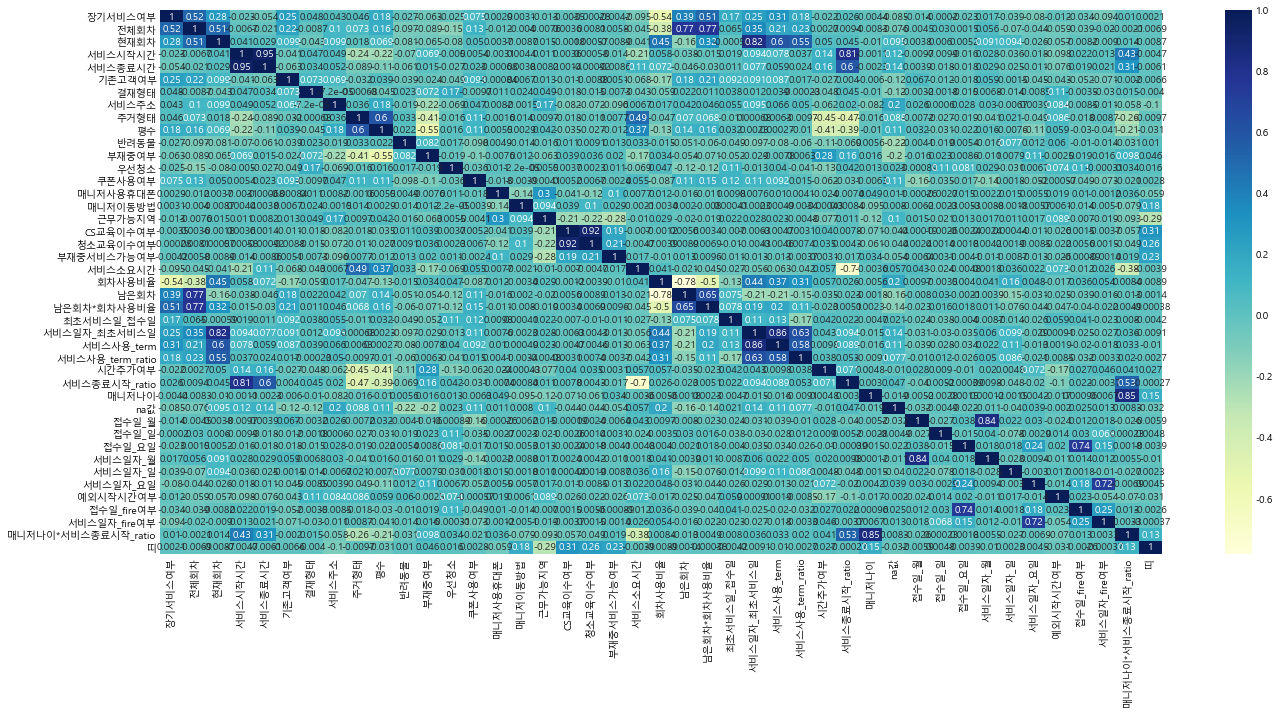

In [496]:
plt.figure(figsize=(20, 10))
sns.heatmap(ftr_imputed.corr(), annot=True, cmap="YlGnBu")
plt.show()

## 스케일링

In [497]:
num_features = list(set(ftr.columns) - set(cat_features))

In [498]:
num_features

['매니저나이',
 '전체회차',
 '매니저나이*서비스종료시작_ratio',
 '서비스일자_최초서비스일',
 '서비스종료시작_ratio',
 '최초서비스일_접수일',
 '현재회차',
 '회차사용비율',
 '남은회차*회차사용비율',
 '서비스사용_term_ratio',
 'na값',
 '서비스소요시간',
 '서비스사용_term']

### Gauss rank
* https://github.com/aldente0630/gauss_rank_scaler

In [499]:
import numpy as np
from joblib import Parallel, delayed
from scipy.interpolate import interp1d
from scipy.special import erf, erfinv
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import FLOAT_DTYPES, check_array, check_is_fitted

class GaussRankScaler(BaseEstimator, TransformerMixin):
    """Transform features by scaling each feature to a normal distribution.
    Parameters
        ----------
        epsilon : float, optional, default 1e-4
            A small amount added to the lower bound or subtracted
            from the upper bound. This value prevents infinite number
            from occurring when applying the inverse error function.
        copy : boolean, optional, default True
            If False, try to avoid a copy and do inplace scaling instead.
            This is not guaranteed to always work inplace; e.g. if the data is
            not a NumPy array, a copy may still be returned.
        n_jobs : int or None, optional, default None
            Number of jobs to run in parallel.
            ``None`` means 1 and ``-1`` means using all processors.
        interp_kind : str or int, optional, default 'linear'
           Specifies the kind of interpolation as a string
            ('linear', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic',
            'previous', 'next', where 'zero', 'slinear', 'quadratic' and 'cubic'
            refer to a spline interpolation of zeroth, first, second or third
            order; 'previous' and 'next' simply return the previous or next value
            of the point) or as an integer specifying the order of the spline
            interpolator to use.
        interp_copy : bool, optional, default False
            If True, the interpolation function makes internal copies of x and y.
            If False, references to `x` and `y` are used.
        Attributes
        ----------
        interp_func_ : list
            The interpolation function for each feature in the training set.
        """

    def __init__(self, epsilon=1e-4, copy=True, n_jobs=None, interp_kind='linear', interp_copy=False):
        self.epsilon = epsilon
        self.copy = copy
        self.interp_kind = interp_kind
        self.interp_copy = interp_copy
        self.fill_value = 'extrapolate'
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        """Fit interpolation function to link rank with original data for future scaling
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The data used to fit interpolation function for later scaling along the features axis.
        y
            Ignored
        """
        X = check_array(X, copy=self.copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True)

        self.interp_func_ = Parallel(n_jobs=self.n_jobs)(delayed(self._fit)(x) for x in X.T)
        return self

    def _fit(self, x):
        x = self.drop_duplicates(x)
        rank = np.argsort(np.argsort(x))
        bound = 1.0 - self.epsilon
        factor = np.max(rank) / 2.0 * bound
        scaled_rank = np.clip(rank / factor - bound, -bound, bound)
        return interp1d(
            x, scaled_rank, kind=self.interp_kind, copy=self.interp_copy, fill_value=self.fill_value)

    def transform(self, X, copy=None):
        """Scale the data with the Gauss Rank algorithm
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The data used to scale along the features axis.
        copy : bool, optional (default: None)
            Copy the input X or not.
        """
        check_is_fitted(self, 'interp_func_')

        copy = copy if copy is not None else self.copy
        X = check_array(X, copy=copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True)

        X = np.array(Parallel(n_jobs=self.n_jobs)(delayed(self._transform)(i, x) for i, x in enumerate(X.T))).T
        return X

    def _transform(self, i, x):
        return erfinv(self.interp_func_[i](x))

    def inverse_transform(self, X, copy=None):
        """Scale back the data to the original representation
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data used to scale along the features axis.
        copy : bool, optional (default: None)
            Copy the input X or not.
        """
        check_is_fitted(self, 'interp_func_')

        copy = copy if copy is not None else self.copy
        X = check_array(X, copy=copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True)

        X = np.array(Parallel(n_jobs=self.n_jobs)(delayed(self._inverse_transform)(i, x) for i, x in enumerate(X.T))).T
        return X

    def _inverse_transform(self, i, x):
        inv_interp_func = interp1d(self.interp_func_[i].y, self.interp_func_[i].x, kind=self.interp_kind,
                                   copy=self.interp_copy, fill_value=self.fill_value)
        return inv_interp_func(erf(x))

    @staticmethod
    def drop_duplicates(x):
        is_unique = np.zeros_like(x, dtype=bool)
        is_unique[np.unique(x, return_index=True)[1]] = True
        return x[is_unique]

In [500]:
scaler = GaussRankScaler()
ftr_imputed[num_features] = pd.DataFrame(scaler.fit_transform(ftr_imputed[num_features]))
ftr_te_imputed[num_features] = pd.DataFrame(scaler.transform(ftr_te_imputed[num_features]))

ftr_imputed[num_features].columns = ftr[num_features].columns
ftr_te_imputed[num_features].columns = ftr[num_features].columns

In [501]:
ftr_imputed.head()

,장기서비스여부,전체회차,현재회차,서비스시작시간,서비스종료시간,기존고객여부,결재형태,서비스주소,주거형태,평수,...,접수일_일,접수일_요일,서비스일자_월,서비스일자_일,서비스일자_요일,예외시작시간여부,접수일_fire여부,서비스일자_fire여부,매니저나이*서비스종료시작_ratio,띠
0,1.0,-0.594939,-0.540560,9.0,13.0,1.0,1.0,6.0,1.0,3.0,...,9.0,1.0,7.0,29.0,0.0,1.0,0.0,0.0,0.397027,0.0
1,1.0,-0.370644,-0.540560,10.0,16.0,1.0,1.0,6.0,1.0,2.0,...,12.0,4.0,8.0,20.0,1.0,0.0,1.0,0.0,-0.860856,8.0
2,1.0,0.906758,0.098979,9.0,13.0,1.0,2.0,6.0,1.0,3.0,...,18.0,2.0,12.0,11.0,4.0,1.0,0.0,1.0,-0.275909,2.0
3,1.0,-0.370644,-0.304408,9.0,14.0,1.0,1.0,5.0,1.0,2.0,...,9.0,0.0,11.0,30.0,0.0,1.0,0.0,0.0,0.169143,0.0
4,1.0,-0.905952,-0.862895,9.0,13.0,1.0,1.0,6.0,1.0,3.0,...,25.0,1.0,4.0,7.0,1.0,1.0,0.0,0.0,-0.091768,10.0


## 모델링

In [502]:
from lightgbm import LGBMClassifier
from xgboost import XGBRFClassifier
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from ngboost import NGBRegressor
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score

In [503]:
kf = StratifiedKFold(n_splits=2, random_state=0, shuffle=True)

In [504]:
cat_features = ['장기서비스여부', '서비스시작시간', '서비스종료시간', '기존고객여부', '결재형태', '서비스주소', '주거형태', 
                '평수', '반려동물', '부재중여부', '우선청소', '쿠폰사용여부', '매니저사용휴대폰', '매니저이동방법', 
                '근무가능지역', 'CS교육이수여부', '청소교육이수여부', '부재중서비스가능여부', '남은회차', '시간추가여부',
                '접수일_월', '접수일_일', '접수일_요일', '서비스일자_월', '서비스일자_일', 
                '서비스일자_요일', '예외시작시간여부', '접수일_fire여부', '서비스일자_fire여부', '띠']

In [505]:
ftr_imputed.shape, target.shape, ftr_te_imputed.shape

((23009, 43), (23009,), (4244, 43))

### RFE

In [122]:
from sklearn.feature_selection import RFECV

In [123]:
model = LGBMClassifier(random_state=0, n_estimators=1000, boost_from_average=True, is_unbalance=True)

In [124]:
rfecv = RFECV(estimator=model, step=1, cv=5, scoring='roc_auc')   #5-fold cross-validation
rfecv = rfecv.fit(ftr_imputed, target)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', ftr_imputed.columns[rfecv.support_])

KeyboardInterrupt: 

In [397]:
X_selected = pd.DataFrame(rfecv.transform(ftr_imputed))
X_te_selected = pd.DataFrame(rfecv.transform(ftr_te_imputed))

X_selected.columns = ftr_imputed.columns[rfecv.support_]
X_te_selected.columns = ftr_imputed.columns[rfecv.support_]

In [398]:
X_selected.shape

(23009, 58)

In [399]:
ftr_imputed = X_selected
ftr_te_imputed = X_te_selected

In [402]:
cat_features = ['장기서비스여부', '서비스시작시간', '서비스종료시간', '기존고객여부', '결재형태', '서비스주소', '주거형태', 
                '평수', '반려동물', '부재중여부', '우선청소', '쿠폰사용여부', '매니저사용휴대폰', '매니저이동방법', 
                '근무가능지역', 'CS교육이수여부', '청소교육이수여부', '부재중서비스가능여부', '추천인여부', '남은회차', 
                '접수일_월', '접수일_주차', '접수일_일', '접수일_요일', '서비스일자_월', '서비스일자_주차', '서비스일자_일', 
                '서비스일자_요일', '예외시작시간여부', '접수일_fire여부', '서비스일자_fire여부']

In [403]:
ftr_imputed.shape

(23009, 58)

### Catboost

In [506]:
ftr_imputed[cat_features] = ftr_imputed[cat_features].astype(float)
ftr_te_imputed[cat_features] = ftr_te_imputed[cat_features].astype(float)

ftr_imputed[cat_features] = ftr_imputed[cat_features].astype(int)
ftr_te_imputed[cat_features] = ftr_te_imputed[cat_features].astype(int)

In [507]:
# catboost data imbalance cover
from sklearn.utils.class_weight import compute_class_weight
 
classes = np.unique(target)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=target)
class_weights = dict(zip(classes, weights))

In [508]:
class_weights

{0: 0.5528086108308107, 1: 5.234076433121019}

In [509]:
cb_pred = np.zeros((ftr_te.shape[0]))
auc_list = []
for tr_idx, val_idx in kf.split(ftr_imputed, target):
    tr_x, val_x = ftr_imputed.iloc[tr_idx], ftr_imputed.iloc[val_idx]
    tr_y, val_y = target.iloc[tr_idx], target.iloc[val_idx]
    train_data = Pool(data=tr_x, label=tr_y, cat_features=cat_features)
    val_data = Pool(data=val_x, label=val_y, cat_features=cat_features)
    cb = CatBoostClassifier(iterations=10000, learning_rate=0.01, eval_metric='AUC', class_weights=class_weights,
                        silent=True, loss_function='Logloss')
    cb.fit(train_data, eval_set=val_data, early_stopping_rounds=1000, use_best_model=True, verbose=2000)
    best = cb.best_iteration_
    pred = cb.predict_proba(val_x, ntree_end=best)[:, 1]
    auc = roc_auc_score(val_y, pred)
    auc_list.append(auc)
    print(f'FOLD ROC-AUC = {auc}')
    sub_pred = cb.predict_proba(ftr_te_imputed, ntree_end=best)[:, 1] / 2
    cb_pred += sub_pred
print(f'\n{cb.__class__.__name__} ROC_AUC_score = {np.mean(auc_list)}')

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	test: 0.7538637	best: 0.7538637 (0)	total: 51.5ms	remaining: 8m 35s
2000:	test: 0.9447472	best: 0.9448275 (1978)	total: 2m 3s	remaining: 8m 13s
4000:	test: 0.9478039	best: 0.9478039 (4000)	total: 4m 11s	remaining: 6m 17s
6000:	test: 0.9489810	best: 0.9490834 (5806)	total: 6m 23s	remaining: 4m 15s
8000:	test: 0.9497352	best: 0.9497829 (7670)	total: 8m 30s	remaining: 2m 7s
9999:	test: 0.9507824	best: 0.9509167 (9678)	total: 10m 39s	remaining: 0us

bestTest = 0.9509166686
bestIteration = 9678

Shrink model to first 9679 iterations.
FOLD ROC-AUC = 0.9508944584185961
0:	test: 0.6324049	best: 0.6324049 (0)	total: 48.9ms	remaining: 8m 8s
2000:	test: 0.9433849	best: 0.9434005 (1985)	total: 2m 3s	remaining: 8m 14s
4000:	test: 0.9455596	best: 0.9455832 (3988)	total: 4m 11s	remaining: 6m 17s
6000:	test: 0.9472676	best: 0.9472746 (5979)	total: 6m 26s	remaining: 4m 17s


KeyboardInterrupt: 

In [510]:
cb_pred.shape

(4244,)

In [511]:
cb_pred

array([1.02388110e-04, 7.14338572e-02, 2.06783592e-01, ...,
       6.66231864e-02, 6.95965695e-03, 3.14859555e-01])

## submission

In [512]:
submission['pred'] = cb_pred

In [513]:
submission['pred'] = submission['pred'].apply(lambda x : 1 if x >=0.5 else 0)

In [514]:
submission['pred'].value_counts()
# 251개 - 0.72
# 330개 - 0.82369
# 344개 - 0.79
# 389개 - 0.848
# 400개 - 0.819

0    4244
Name: pred, dtype: int64

In [391]:
submission['pred'] = cb_pred
submission = submission.set_index('SEQ')
submission

,pred
SEQ,
T54370,0.000807
T47892,0.296034
T56637,0.486022
T45487,0.001317
T41995,0.331398
...,...
T31589,0.091153
T36236,0.113998
T34729,0.117570


In [392]:
submission.to_csv('submission/1123_cb_gr_2fold_pyeong6.csv')

<AxesSubplot:>

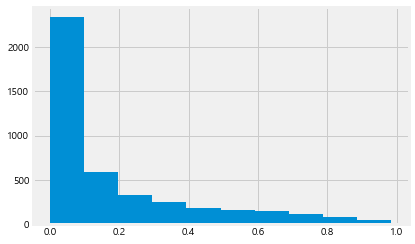

In [393]:
submission['pred'].hist()

In [394]:
submission

,pred
SEQ,
T54370,0.000807
T47892,0.296034
T56637,0.486022
T45487,0.001317
T41995,0.331398
...,...
T31589,0.091153
T36236,0.113998
T34729,0.117570
